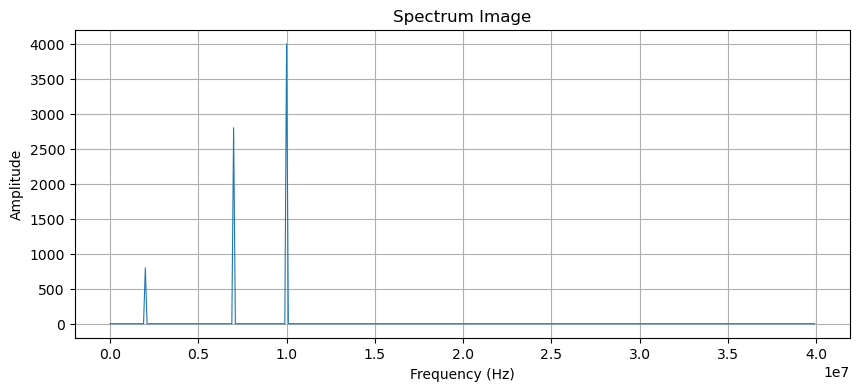

In [189]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_sparse_coded_signal
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV

'''
n_components, n_features = 512, 100 #n_components是传感矩阵的列数n，n_features是传感矩阵的行数，也就是观测向量Y的行数m
n_nonzero_coefs = 17    #这个是非0元素的个数

# generate the data

# Y = WX
# |x|_0 = n_nonzero_coefs

Y, W, X = make_sparse_coded_signal(
    n_samples=1,
    n_components=n_components,
    n_features=n_features,
    n_nonzero_coefs=n_nonzero_coefs,
    random_state=0,
)

# W = W.T #W是传感矩阵 这里经过验证，根本不需要转置，源代码有误
'''

m, n = 40,800
# 128x256矩阵，每个元素服从Gauss随机分布
A = np.random.randn(m, n)

# 设置时间参数
t = np.linspace(0, 1e-5, n, endpoint=False)  # 1秒内采样10000次
# 生成信号
signal_2M = 2 * np.cos(2 * np.pi * 2e6 * t)  # 幅度为2
signal_7M = 7 * np.cos(2 * np.pi * 7e6 * t)  # 幅度为7
signal_10M = 10 * np.cos(2 * np.pi * 10e6 * t)  # 幅度为10

# 叠加信号
final_signal = signal_2M + signal_7M + signal_10M

# 频域图像
# 进行FFT
fft_result = np.fft.fft(final_signal)
fft_freq = np.fft.fftfreq(len(t), t[1] - t[0])  # 计算频率

# 取FFT结果的绝对值，得到幅度谱
fft_amplitude = np.abs(fft_result)
threshold = 1e-10
# fft_amplitude[fft_amplitude < threshold] = 0 #这段代码的意思是，把FFT后很接近0的点都直接变为0
fft_amplitude_transpose = (fft_amplitude).reshape(len(fft_amplitude) ,1)

# 绘制频谱
plt.figure(figsize=(10, 4))
plt.plot(fft_freq[:len(fft_freq)//2], fft_amplitude[:len(fft_amplitude)//2], linewidth=0.8)  # 只显示正频率部分
plt.title('Spectrum Image')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



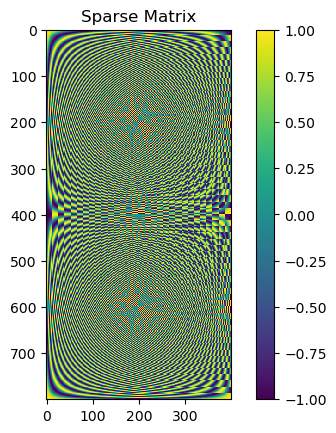

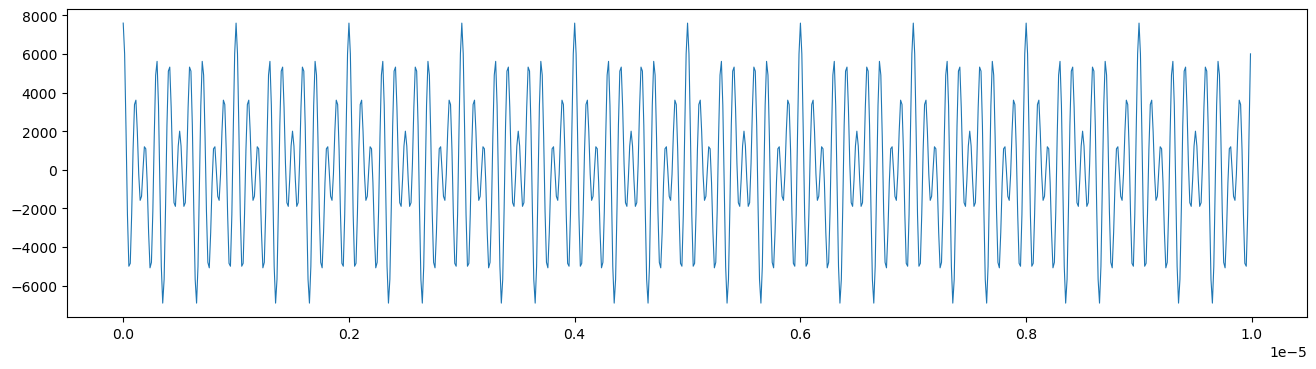

In [190]:
# 生成稀疏矩阵
def generate_fourier_transform_matrix(n, m):
    F = np.zeros((n, m))
    for k in range(m):
        for p in range(n):
            F[p, k] = np.cos (2 * np.pi * k * p / n) #这行代码是生成一个稀疏矩阵，输入n是时域采样的长度，这里是800个点，m是正半频域采样的长度，这里是800/2=400
    return F

F = generate_fourier_transform_matrix(len(t), len(fft_freq)//2)

plt.imshow(F, cmap='viridis', interpolation='nearest')
plt.colorbar()  # 添加颜色条
plt.title('Sparse Matrix')
plt.show()

fft_amplitude_half_vector = (fft_amplitude[:len(fft_amplitude)//2]).reshape(len(fft_amplitude)//2 ,1)

time_domain_signal = np.dot(F, fft_amplitude_half_vector)

plt.figure(figsize=(16, 4))
plt.plot(t, time_domain_signal, linewidth = 0.8)

400


d:\ANACONDA\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
d:\ANACONDA\lib\site-packages\sklearn\linear_model\_omp.py:418: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


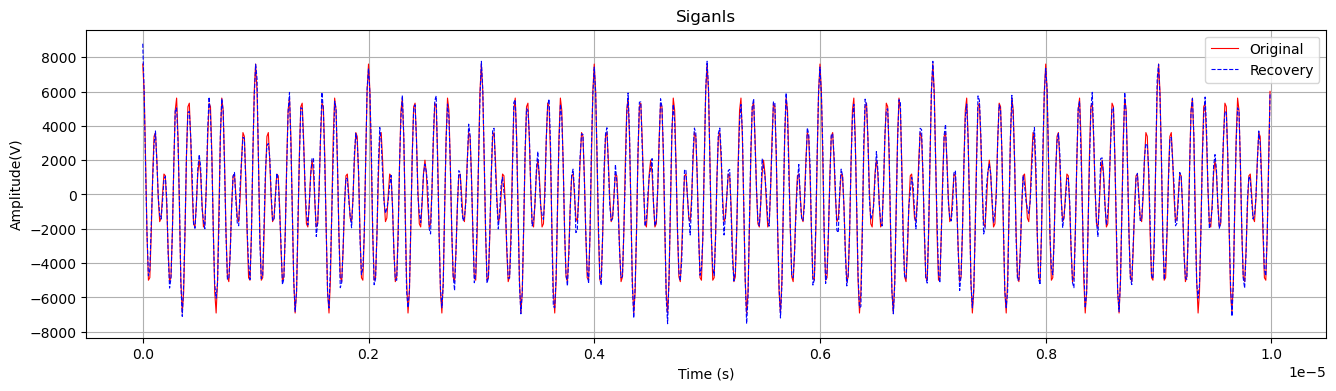

' \nplt.subplot(4, 1, 2)\nplt.xlim(0, 512)\nplt.title("Recovered signal from noise-free measurements")\nplt.stem(idx_r, coef[idx_r])\n'

In [193]:
W = np.dot(A, F)
X = fft_amplitude_half_vector
Y = np.dot(W, X)

print(len(X))
idx = X.nonzero() #X中非零元素的索引
idx = idx[0] #这个idx原本会有两列，右边那列是全0的，因此只取左边的那列

# distort the clean signal
Y_noisY = Y + 0.05 * np.random.randn(len(Y))

n_features = m
n_nonzero_coefs = len(idx)

Y = Y.reshape(-1, 1)  #将 Y 从原来的一维数组（形状为 (512,)）转变为一个列向量，形状为 (512, 1)。这个操作保持了 Y 中的所有元素，但将其重新组织成了一个列向量的形式。
W = W.reshape(n_features, -1)



# plot the noise-free reconstruction
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(W, Y)
coef = omp.coef_  #这个coef就是一个1×400的一个fft——amplitude
# (idx_r,) = coef.nonzero()

reconstructed_signal = np.dot(F, coef)  #这个是重建后的时域信号

# 绘制信号
plt.figure(figsize=(16, 4))
plt.plot(t, time_domain_signal, 'r', linewidth = 0.8, label = 'Original')  #原信号
plt.plot(t, reconstructed_signal, 'b--',linewidth = 0.8, label = 'Recovery') #恢复后的信号，都是时域的
plt.legend()
plt.title('Siganls')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude(V)')
plt.grid(True)
plt.show()
#下面这个源代码画出来的图太丑了
''' 
plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r])
'''

(400, 1)
(40, 400)
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.85228542e+02  0.00000000e+00  1.49304486e+02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.03363760e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  8.80105125e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.49225734e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00

d:\ANACONDA\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
d:\ANACONDA\lib\site-packages\sklearn\linear_model\_omp.py:418: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


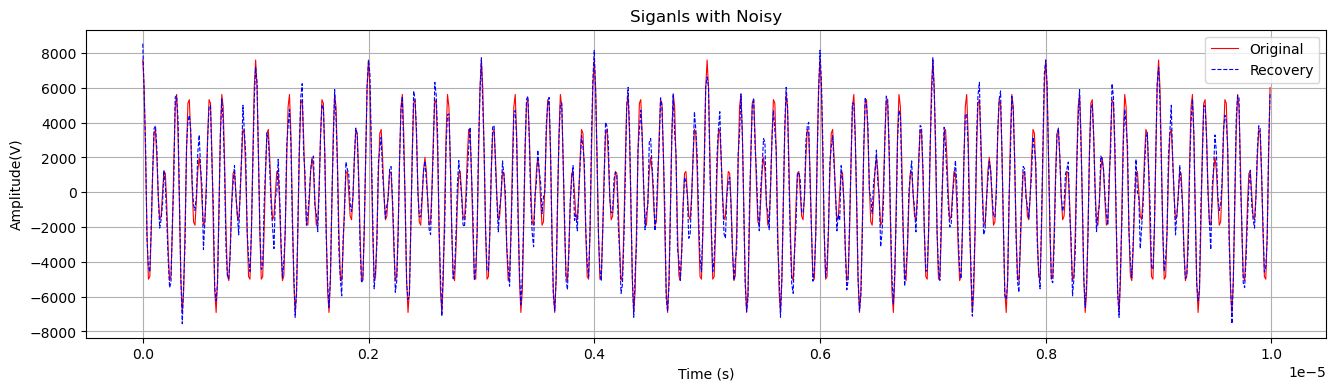

'\n# plot the noisy reconstruction\nomp.fit(X, y_noisy)\ncoef = omp.coef_\n(idx_r,) = coef.nonzero()\nplt.subplot(4, 1, 3)\nplt.xlim(0, 512)\nplt.title("Recovered signal from noisy measurements")\nplt.stem(idx_r, coef[idx_r])\n'

In [194]:
# 叠加噪声
SNR_dB = 20
SNR_linear = 10**(SNR_dB / 10)  # 转换为线性信噪比
noise_power = np.var(final_signal) / SNR_linear  # 计算噪声功率
noise = np.sqrt(noise_power) * np.random.randn(len(final_signal))  # 生成高斯白噪声

final_signal = final_signal + noise

# 频域图像
# 进行FFT
fft_result = np.fft.fft(final_signal)
fft_freq = np.fft.fftfreq(len(t), t[1] - t[0])  # 计算频率

# 取FFT结果的绝对值，得到幅度谱
fft_amplitude = np.abs(fft_result)
threshold = 1e-10
fft_amplitude[fft_amplitude < threshold] = 0 #这段代码的意思是，把FFT后很接近0的点都直接变为0
fft_amplitude_transpose = (fft_amplitude).reshape(len(fft_amplitude) ,1)

fft_amplitude_half_vector = (fft_amplitude[:len(fft_amplitude)//2]).reshape(len(fft_amplitude)//2 ,1)

W = np.dot(A, F)
X = fft_amplitude_half_vector
print(X.shape)
print(W.shape)
Y_noisY = np.dot(W, X)



omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(W, Y_noisY)
coef = omp.coef_ 
print(coef)
reconstructed_signal_noisY = np.dot(F, coef)  #这个是重建后的时域信号

# 绘制信号
plt.figure(figsize=(16, 4))
plt.plot(t, time_domain_signal, 'r', linewidth = 0.8, label = 'Original')  #原信号
plt.plot(t, reconstructed_signal_noisY, 'b--',linewidth = 0.8, label = 'Recovery') #恢复后的信号，都是时域的
plt.legend()
plt.title('Siganls with Noisy')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude(V)')
plt.grid(True)
plt.show()
#print(F)
'''
# plot the noisy reconstruction
omp.fit(X, y_noisy)
coef = omp.coef_
(idx_r,) = coef.nonzero()
plt.subplot(4, 1, 3)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements")
plt.stem(idx_r, coef[idx_r])
'''
